In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_epft_chr22_norm'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score        gc  \
0        22  17736387  17736396      -  ENSG00000015475    0.0  0.699989   
1        22  17736397  17736406      -  ENSG00000015475    0.0  0.699989   
2        22  17736407  17736416      -  ENSG00000015475    0.0  0.699989   
3        22  17736417  17736426      -  ENSG00000015475    0.0  0.158013   
4        22  17736427  17736436      -  ENSG00000015475    0.0  1.241965   

       rpts      ctcf   histone  sj5  sj3  dms  lambda_alphaj      zeta  
0 -0.491843 -0.061105 -0.295750  0.0  0.0  0.0       0.211445  1.204263  
1 -0.491843 -0.061805 -0.309448  0.0  0.0  0.0       0.211445  1.203544  
2 -0.491843 -0.061114 -0.297420  0.0  0.0  0.0       0.211445  1.204176  
3 -0.491843 -0.061809 -0.309120  0.0  0.0  0.0       0.211445  1.056701  
4 -0.491843 -0.061809 -0.309495  0.0  0.0  0.0       0.211445  1.370809  


In [3]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]#[6:-7]
num_features = len(feature_names)
#nucleotides = column_names[-6:-2]
print(feature_names)
#print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['gc' 'rpts' 'ctcf' 'histone' 'sj5' 'sj3' 'dms']


In [4]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 449874


In [5]:
print("Number of Features: " + str(num_features))

Number of Features: 7


In [6]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values#df.iloc[:, 6:-7].values

In [7]:
C_j = df['lambda_alphaj'].values

In [8]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: True
Number of GPUs available: 1


In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [10]:
dataset = CustomDataset(Y_ji, X_ji, C_j, Z_ji)

train_percent = 0.8
val_percent = 0.1
test_percent = 0.1
train_size = int(train_percent * num_samples)
val_size = int(val_percent * num_samples)
test_size = num_samples - train_size - val_size
trnset, valset, tstset = td.random_split(dataset, [train_size, val_size, test_size])

batch_size = 64

In [11]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)

#class CNN(nn.Module):
#    def __init__(self):
#        super(CNN, self).__init__()
#        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=1)
#        self.pool = nn.MaxPool1d(2, 2)
#        self.fc = nn.Linear(64, 1)  

#    def forward(self, x):
#        x = x.unsqueeze(1)
#        x = self.pool(F.relu(self.conv1(x)))
#        x = torch.flatten(x, 1)
#        x = self.fc(x)
#        return x
    
#model = CNN()

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=7, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 8
Model is on device: cuda:0


In [12]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(trnset, batch_size=batch_size, num_workers=7, shuffle=True, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl
    
    model.eval()
    valdl = DataLoader(valset, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: 0.4146 val_loss: 0.3997
Epoch 2
Epoch 2 trn_loss: 0.3972 val_loss: 0.3966
Epoch 3
Epoch 3 trn_loss: 0.3959 val_loss: 0.3965
Epoch 4
Epoch 4 trn_loss: 0.3959 val_loss: 0.3965
Epoch 5
Epoch 5 trn_loss: 0.3959 val_loss: 0.3965
Epoch 6
Epoch 6 trn_loss: 0.3959 val_loss: 0.3965
Epoch 7
Epoch 7 trn_loss: 0.3959 val_loss: 0.3965
Epoch 8
Epoch 8 trn_loss: 0.3959 val_loss: 0.3965
Epoch 9
Epoch 9 trn_loss: 0.3959 val_loss: 0.3965
Epoch 10
Epoch 10 trn_loss: 0.3959 val_loss: 0.3965
Epoch 11
Epoch 11 trn_loss: 0.3959 val_loss: 0.3966
Epoch 12
Epoch 12 trn_loss: 0.3959 val_loss: 0.3966
Epoch 13
Epoch 13 trn_loss: 0.3959 val_loss: 0.3965
Epoch 14
Epoch 14 trn_loss: 0.3959 val_loss: 0.3965
Epoch 15
Epoch 15 trn_loss: 0.3959 val_loss: 0.3965
Epoch 16
Epoch 16 trn_loss: 0.3959 val_loss: 0.3965
Epoch 17
Epoch 17 trn_loss: 0.3959 val_loss: 0.3965
Epoch 18
Epoch 18 trn_loss: 0.3959 val_loss: 0.3965
Epoch 19
Epoch 19 trn_loss: 0.3959 val_loss: 0.3965
Epoch 20
Epoch 20 trn_loss: 0.

In [14]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "models/Elongation_Model_50_epochs2.pth"#f"models/Elongation_Model_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [107]:
"""
model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

CUDA (GPU support) is available: True
Number of GPUs available: 1
Model is on device: cuda:0


In [15]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"gc": -0.0029967892915010452, "rpts": 0.000715675123501569, "ctcf": -6.215643225004897e-05, "histone": -0.002069163369014859, "sj5": -0.003401409601792693, "sj3": -0.0006071178358979523, "dms": -0.0014902298571541905


In [ ]:
# GLM K

# ctcf: -0.008355491
# sj5: -0.114737868
# sj3: -0.181587543
# dms: -0.080544917
# rpts: 0.063179057

# gc: -0.240107566
# histone: -0.043173335

<function matplotlib.pyplot.show(close=None, block=None)>

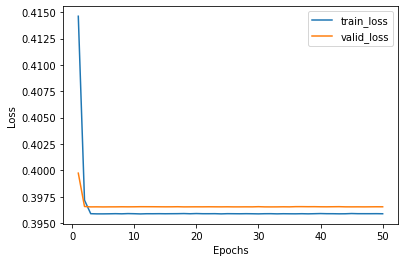

In [16]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [17]:
def plot_data(simulated_zeta, predicted_zeta):
    indices = range(len(simulated_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, predicted_zeta, color='blue', label='Predicted Zeta')
    ax.scatter(indices, simulated_zeta, color='orange', label='Simulated Zeta')
    
    ax.set_title('Predicted vs Simulated Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [18]:
tstdl = DataLoader(tstset, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [19]:
model.eval()

data_iter = iter(tstdl)

number of samples: 4
predicted zeta:
tensor([0.9130, 0.9096, 0.9126, 0.9103, 0.9191, 0.9151, 0.9243, 0.9186, 0.9146,
        0.9176, 0.9131, 0.9103, 0.9179, 0.9176, 0.9117, 0.9102, 0.9159, 0.9116,
        0.9160, 0.9206, 0.9130, 0.9132, 0.9159, 0.9102, 0.9149, 0.9120, 0.9146,
        0.9154, 0.9163, 0.9157, 0.9162, 0.9107, 0.9207, 0.9160, 0.9145, 0.9146,
        0.9129, 0.9131, 0.9084, 0.9115, 0.9146, 0.9191, 0.9152, 0.9146, 0.9132,
        0.9129, 0.9131, 0.9163, 0.9133, 0.9117, 0.9133, 0.9116, 0.9133, 0.9096,
        0.9102, 0.9119, 0.9163, 0.9193, 0.9146, 0.9132, 0.9178, 0.9162, 0.9156,
        0.9064])
simulated zeta:
tensor([1.2117, 1.7001, 1.1163, 1.5630, 0.7175, 1.0609, 0.5733, 0.7247, 1.0611,
        0.8174, 1.2088, 1.5621, 0.7918, 0.8166, 1.3742, 1.5091, 0.7811, 1.3774,
        0.9336, 0.6299, 1.2109, 1.2047, 0.8869, 1.5655, 1.0276, 1.0898, 1.0601,
        1.0239, 0.9036, 1.0789, 0.9287, 1.2186, 0.6285, 0.9321, 1.0623, 1.0333,
        1.2134, 1.2085, 1.3970, 1.3817, 1.0611, 0.

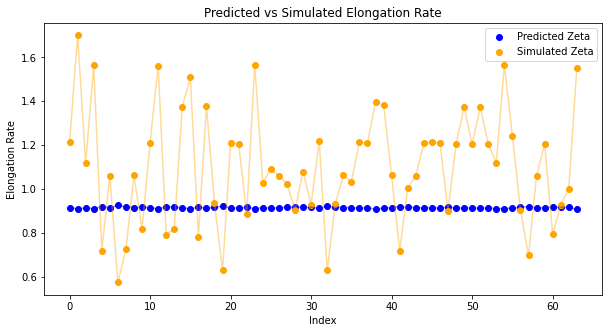

number of samples: 4
predicted zeta:
tensor([0.9199, 0.9125, 0.9147, 0.9178, 0.9162, 0.9131, 0.9100, 0.9134, 0.9148,
        0.9131, 0.9063, 0.9162, 0.9143, 0.9161, 0.9192, 0.9117, 0.9131, 0.9147,
        0.9134, 0.9222, 0.9063, 0.9206, 0.9110, 0.9147, 0.9201, 0.9123, 0.9176,
        0.9160, 0.9206, 0.9209, 0.9065, 0.9158, 0.9163, 0.9148, 0.9179, 0.9170,
        0.9192, 0.9169, 0.9191, 0.9131, 0.9149, 0.9114, 0.9148, 0.9147, 0.9132,
        0.9117, 0.9191, 0.9145, 0.9107, 0.9147, 0.9168, 0.9189, 0.9118, 0.9176,
        0.9224, 0.9116, 0.9179, 0.9151, 0.9116, 0.9105, 0.9149, 0.9132, 0.9190,
        0.9131])
simulated zeta:
tensor([0.6400, 1.2250, 1.0579, 0.7383, 0.9292, 0.9048, 1.5721, 1.1698, 1.0297,
        1.2079, 1.4334, 0.9288, 1.0683, 0.9313, 0.7160, 1.3727, 1.2091, 1.0594,
        1.1693, 0.5372, 2.3013, 0.6295, 1.3214, 1.0073, 0.6762, 1.2318, 0.8553,
        0.9323, 0.7313, 0.6103, 1.9410, 0.9370, 0.9035, 1.0283, 0.7074, 0.9233,
        0.6977, 0.8301, 0.7079, 1.2076, 1.0680, 1.

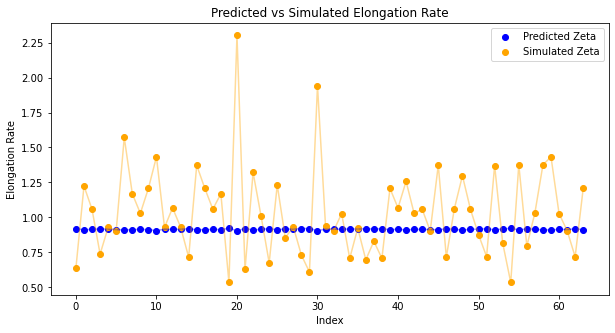

number of samples: 4
predicted zeta:
tensor([0.9195, 0.9155, 0.9131, 0.9144, 0.9145, 0.9114, 0.9181, 0.9132, 0.9159,
        0.9116, 0.9103, 0.9118, 0.9206, 0.9188, 0.9191, 0.9144, 0.9076, 0.9192,
        0.9161, 0.9146, 0.9120, 0.9129, 0.9056, 0.9161, 0.9111, 0.9117, 0.9119,
        0.9183, 0.9177, 0.9176, 0.9161, 0.9131, 0.9173, 0.9140, 0.9188, 0.9132,
        0.9146, 0.9190, 0.9146, 0.9108, 0.9115, 0.9161, 0.9161, 0.9176, 0.9039,
        0.9060, 0.9178, 0.9206, 0.9162, 0.9128, 0.9147, 0.9176, 0.9114, 0.9134,
        0.9090, 0.9133, 0.9161, 0.9163, 0.9143, 0.9101, 0.9128, 0.9172, 0.9174,
        0.9118])
simulated zeta:
tensor([0.6960, 0.9497, 1.2082, 1.0651, 1.0625, 0.9696, 0.7671, 0.8570, 0.9347,
        1.3267, 1.5622, 1.3720, 0.6291, 0.7222, 0.7174, 1.0646, 1.9944, 0.7160,
        0.9310, 1.0615, 1.0385, 1.0739, 1.8811, 0.9300, 0.9235, 1.3740, 1.0252,
        0.6306, 0.8159, 0.8164, 0.9300, 1.2079, 0.8221, 1.3596, 0.9056, 1.2068,
        1.0610, 0.7006, 1.0601, 1.4340, 0.8718, 0.

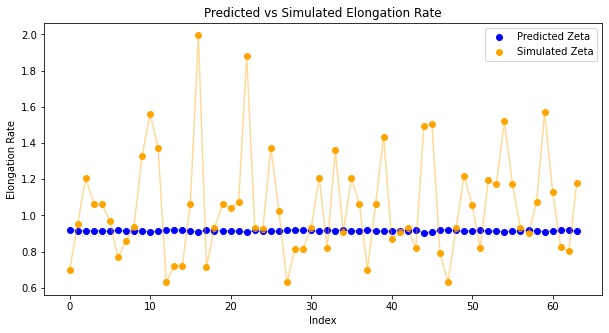

number of samples: 4
predicted zeta:
tensor([0.9132, 0.9144, 0.9147, 0.9147, 0.9118, 0.9100, 0.9146, 0.9114, 0.9129,
        0.9143, 0.9162, 0.9161, 0.9128, 0.9140, 0.9177, 0.9119, 0.9125, 0.9183,
        0.9122, 0.9145, 0.9146, 0.9117, 0.9110, 0.9176, 0.9207, 0.9146, 0.9147,
        0.9122, 0.9130, 0.9159, 0.9159, 0.9166, 0.9118, 0.9163, 0.9149, 0.9192,
        0.9219, 0.9050, 0.9190, 0.9089, 0.9126, 0.9159, 0.9191, 0.9131, 0.9146,
        0.9132, 0.9161, 0.9164, 0.9223, 0.9176, 0.9129, 0.9134, 0.9132, 0.9145,
        0.9206, 0.9187, 0.9161, 0.9115, 0.9082, 0.9130, 0.9067, 0.9150, 0.9190,
        0.9124])
simulated zeta:
tensor([1.2061, 1.0653, 1.0587, 1.0578, 1.3717, 1.4293, 1.0615, 1.5270, 1.2133,
        1.0690, 0.9281, 0.9309, 1.2170, 1.0752, 0.8162, 1.3337, 1.2253, 0.7306,
        1.3320, 1.0641, 1.0606, 1.3730, 1.1215, 0.8173, 0.6286, 1.0608, 1.0583,
        1.0182, 1.2107, 0.9359, 0.9362, 0.8745, 1.1229, 0.9032, 0.9566, 0.6677,
        0.5557, 1.4551, 0.7182, 1.3317, 1.2231, 0.

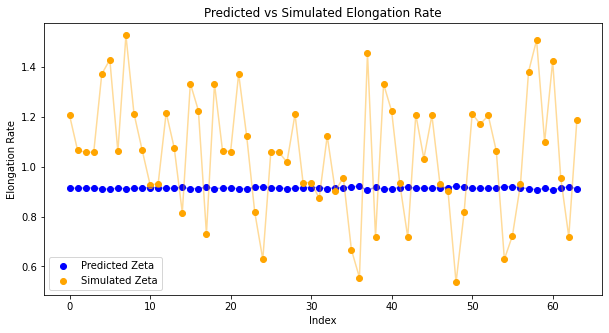

In [20]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    simulated_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    predicted_zeta = torch.exp(rho_ji.cpu().squeeze())
    print("predicted zeta:")
    print(predicted_zeta)

    print("simulated zeta:")
    print(simulated_zeta)

    plot_data(simulated_zeta, predicted_zeta)

In [114]:
import torch.nn.functional as F

predicted_zeta = []
simulated_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        predicted_zeta.append(torch.exp(rho_ji.cpu()))
        simulated_zeta.append(batch['Z_ji'])

predicted_zeta = torch.cat(predicted_zeta, dim=0)
simulated_zeta = torch.cat(simulated_zeta, dim=0)
mae = F.l1_loss(predicted_zeta.squeeze(), simulated_zeta)
mse = F.mse_loss(predicted_zeta.squeeze(), simulated_zeta)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Mean Absolute Error: 1.4545
Mean Squared Error: 2.1965
